In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal

In [2]:
%matplotlib inline

In [24]:
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, batch_size=128, 
                 epsilon=0.2, epoch_n=40, pi_lr=1e-4, v_lr=1e-3):

        super().__init__()
        
        self.action_dim = action_dim
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.pi_model_base = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU()).to(self.device)
        self.pi_model_m = nn.Sequential(nn.Linear(128, action_dim), nn.Tanh())
        self.pi_model_s = nn.Sequential(nn.Linear(128, action_dim))
        
        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1)).to(self.device)
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(
            list(self.pi_model_base.parameters())+list(self.pi_model_m.parameters())+list(self.pi_model_s.parameters()),
            lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)
        
    def forward_pi(self, state):
        x = self.pi_model_base(state)
        
        return self.pi_model_m(x), self.pi_model_s(x)

    def get_action(self, state, rand_factor = 1):
        mean, log_std = self.forward_pi(torch.FloatTensor(state))
        dist = Normal(mean, rand_factor*torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(self.action_dim)
    
    def to_cpu(self):
        self.pi_model_base.to('cpu')
        self.pi_model_m.to('cpu')
        self.pi_model_s.to('cpu')
        self.v_model.to('cpu')
        
    def to_dev(self):
        self.pi_model_base.to(self.device)
        self.pi_model_m.to(self.device)
        self.pi_model_s.to(self.device)
        self.v_model.to(self.device)

    def fit(self, states, actions, rewards, dones):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])
        states, actions, returns = states.to(self.device), actions.to(self.device), returns.to(self.device)

        mean, log_std = self.forward_pi(states)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_returns.detach() - self.v_model(b_states)
                
                b_mean, b_log_std = self.forward_pi(b_states)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

In [25]:
env = gym.make("LunarLander-v2", continuous = True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPO(state_dim, action_dim)

total_rewards = []

In [26]:
%%time

episode_n = 50
trajectory_n = 20

for episode in range(episode_n):

    states, actions, rewards, dones = [], [], [], []
    
    agent.to_cpu()
    for _ in range(trajectory_n):
        total_reward = 0

        state = env.reset()
        for t in range(1000):
            states.append(state)
            
            action = agent.get_action(state)
            actions.append(action)
            
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            dones.append(done)

            total_reward += reward
            if done:
                break
            
        total_rewards.append(total_reward)
    agent.to_dev()
    agent.fit(states, actions, rewards, dones)
    
    print(episode,total_reward,end='\r')

CPU times: total: 9min 55s
Wall time: 59min 32s


In [27]:
hist = np.array([[i for i in range(len(total_rewards))],total_rewards]).T

In [28]:
np.savetxt('ppo4.txt',hist)

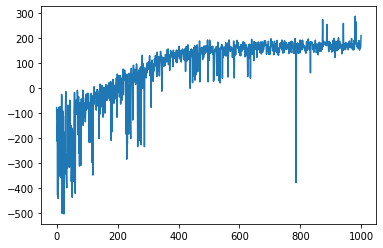

In [29]:
plt.plot(hist[:,1])

In [ ]:
#